# Predicting the past, Europe

## Introduction

The Power Reactor Information System (PRIS) publishes information about nuclear reactors around the world. Reactors deployed in Europe are obtained from the spreadsheet published by PRIS to run a benchmarking simulation. _CYCLUS_, an agent-based simulation software is used and analysis of the results is performed. Only commercial reactors are considered for this simulation, and nuclear reactors from the following countries are included: Belgium, Bulgaria, Czechoslovakia, Finland, France, Germany, Italy, Netherlands, Romania, Russia, Slovenia, Spain, Sweden, Switzerland, and the United Kingdom.

## Obtaining Recipes for Simulation

First, an input file for _CYCLUS_ specifying the recipes for fresh and spent nuclear fuel (SNF) is produced. The recipes for fresh and SNF are obtained from [vision_recipes.xls](import_data/vision_recipies/vision_recipies.xls) spreadsheet file, which contains isotopes and compositions for fresh and SNF for uranium oxide (UOX) and mixed oxide (MOX) fuel at different burn ups.

Importing raw composition data from `vision_recipes.xls` is performed with a python script and is demonstrated below. Due to limited information about the reactors, all reactors are assumed to operate at a burn up of 51 GWd/MTHM.

### Demonstration
__Import necessary libraries__

In [1]:
import csv
import collections
import dateutil.parser as date
import import_fleetcomp as idata
import jinja2
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import sys
import sqlite3 as lite
from matplotlib import cm
from pyne import nucname as nn
from IPython.display import Image

sys.path.append('analysis/')
import analysis as an

region = 'europe'

__Read fuel recipe data__

`vision_recipes.xls` is stored to a list object by looping over each row in the spreadsheet file.

In [2]:
def import_csv(in_csv, delimit):
    """ Imports contents of a comma delimited csv file
    to a 2D list.

    Parameters
    ---------
    in_csv: str
        csv file name.
    delimit: str
        delimiter of the csv file

    Returns
    -------
    data_list: list
        list with fleetcomp data.
    """
    with open(in_csv, encoding='utf-8') as source:
        sourcereader = csv.reader(source, delimiter=delimit)
        data_list = []
        for row in sourcereader:
            data_list.append(row)
    return data_list


recipes = import_csv('import_data/vision_recipes/uox.csv', ',')
print(*recipes[2:6], '.', '.', '.', sep='\n')

['He4', '0', '2.09687731425456E-07', '0', '9.47457840128509E-07', '0', '2.0692755421168E-06', '0']
['Ra226', '0', '1.18893043712383E-14', '0', '9.78856442957042E-14', '0', '0', '0']
['Ra228', '0', '6.05164592554536E-21', '0', '2.75087759176098E-20', '0', '6.0138599011451E-20', '0']
['Pb206', '0', '7.66855132237399E-20', '0', '5.57475193532078E-18', '0', '1.40345550165974E-17', '0']
.
.
.


__Load template for _CYCLUS_ input file__

A jinja template file, used to produce parts of the final _CYCLUS_ simulation input file, is loaded to memory.

In [3]:
def load_template(in_template):
    """ Returns a jinja2 template.

    Parameters
    ---------
    in_template: str
        template file name.

    Returns
    -------
    output_template: jinja template object
    """
    with open(in_template, 'r') as default:
        output_template = jinja2.Template(default.read())
    return output_template


recipe_template = load_template('templates/recipes_template.xml')

__Select appropriate recipe for a given burnup__

The appropriate composition for fresh and spent nuclear fuel is selected by specifying burnup. The composition data is then stored into a dictionary object with {isotope: mass fraction composition} as {key : value} pair.

In [4]:
def get_composition_fresh(in_list, burnup):
    """ Returns a dictionary of isotope and composition (in mass fraction)
    using vision_recipes for fresh UOX

    Parameters
    ---------
    in_list: list
        list file containing vision_recipes data.
    burnup: int
        burnup

    Returns
    -------
    data_dict: dictionary
        dictionary with key: isotope, and value: composition.
    """
    data_dict = {}
    for i in range(len(in_list)):
        if i > 1:
            if burnup == 33:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][1])})
            elif burnup == 51:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][3])})
            else:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][5])})
    return data_dict


def get_composition_spent(in_list, burnup):
    """ Returns a dictionary of isotope and composition (in mass fraction)
    using vision_recipes for spent nuclear fuel

    Parameters
    ---------
    in_list: list
        list file containing vision_recipes data.
    burnup: int
        burnup

    Returns
    -------
    data_dict: dictionary
        dictionary with key: isotope, and value: composition.
    """
    data_dict = {}
    for i in range(len(in_list)):
        if i > 1:
            if burnup == 33:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][2])})
            elif burnup == 51:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][4])})
            else:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][6])})
    return data_dict


fresh = get_composition_fresh(recipes, 51)
spent = get_composition_spent(recipes, 51)
print('Spent Fuel Composition:')
print('ISOTOPE:   Massfrac')
for k in list(spent.keys())[:3]:
    print(k, ': ', spent[k])
print('.', '.', '.', sep='\n')

Spent Fuel Composition:
ISOTOPE:   Massfrac
20040000 :  9.47457840128509e-07
882260000 :  9.78856442957042e-14
882280000 :  2.75087759176098e-20
.
.
.


__Render recipe template with recipe data__

`jinja2` library is used to render recipe data to the previously loaded `recipe_template`. `pyne` library is used to convert the isotope names to _CYCLUS_ readable format. The rendered information is then saved to an xml file for use with _CYCLUS_.

In [5]:
def write_recipes(fresh_dict, spent_dict, in_template, burnup, region):
    """ Renders jinja template using fresh and spent fuel composition and
    outputs an xml file containing recipe data

    Parameters
    ---------
    fresh_dict: dictionary
        dictionary with key=isotope, and value=composition for fresh UOX
    spent_dict: dictionary
        dictionary with key=isotope, and value=composition for spent fuel
    in_template: jinja template object
        jinja template object to be rendered.
    burnup: int
        amount of burnup

    Returns
    -------
    null
        generates reactor files for cyclus.
    """
    out_path = 'cyclus/input/' + region + '/recipes/'
    pathlib.Path(out_path).mkdir(parents=True, exist_ok=True)
    rendered = in_template.render(fresh=fresh_dict,
                                  spent=spent_dict)
    with open(out_path + '/uox_' +
              str(burnup) + '.xml', 'w') as output:
        output.write(rendered)


write_recipes(fresh, spent, recipe_template, 33, region)
write_recipes(fresh, spent, recipe_template, 51, region)
write_recipes(fresh, spent, recipe_template, 100, region)


`jinja2` library is used to produce various parts of the final  _CYCLUS_ input file using templates. The library replaces simulation-specific information, such as the recipe for SNF, from the specified template file. This allows end-users to produce _CYCLUS_ simulation inputs that vary depending on the data with which they have been rendered. An example is shown below.

Recipe template file:

```
    <recipes>
      <recipe>
        <name>fresh_uox</name>
        <basis>atom</basis>
        <nuclide>
          <id>922350000</id>
          <comp>4.5</comp>
        </nuclide>
        <nuclide>
          <id>922380000</id>
          <comp>95.5</comp>
        </nuclide>
      </recipe>
      <recipe>
        <name>spent_uox</name>
        <basis>atom</basis>
        {% for key, value in vision.items() -%}
        <nuclide>  <id>{{ key }}</id>  <comp>{{ value }}</comp>  </nuclide>
        {% endfor -%}
      </recipe>
    </recipes>
```

The template shown above is a recipe template. `jinja2` recognizes variables within the brackets (`{{ }}`) and replaces the variables with appropriate values. The library also recognizes loops to produce multiple lines of text from a list of data. For instance, `jinja2` used the for-loop in the following lines
```
    {% for key, value in vision.items() -%}`
    <nuclide>  <id>{{ key }}</id>  <comp>{{ value }}</comp>  </nuclide>
    {% endfor -%}
```
and iterated over the composition dictionary to render the isotope and its composition.

[uox_51.xml](cyclus/input/US/recipes/uox_51.xml) is the rendered result. 

## Obtaining Deployment Data

Reactors specified in [reactors_pris_2016.csv](import_data/reactors_pris_2016.csv), need to be properly imported. The reactors should be deployed at the correct timesteps for an accurate simulation. The spreadsheet file contains reactor information including the name, deployment date, net capacity, and deployment nation. Obtaining reactor information for _CYCLUS_ is performed using a set of python functions. The same generic steps were repeated for this demonstration: importing data stored in a delimited text file, and rendering the imported data to a _CYCLUS_ template file using `jinja2`.

### Demonstration
__Read fleetcomp reactor data__

In [6]:
pris = import_csv('import_data/reactors_pris_2016.csv', ',')
print(*pris[1:6], sep='\n')
print('.', '.', '.', sep='\n')

['Argentina', 'ATUCHA-1', 'PHWR', '335', 'Operational', 'NASA', '6/1/1968', '1968', '1/13/1974', '3/19/1974', '6/24/1974', '', '83.1']
['Argentina', 'EMBALSE', 'PHWR', '600', 'Operational', 'NASA', '4/1/1974', '1974', '3/13/1983', '4/25/1983', '1/20/1984', '', '69.6']
['Argentina', 'ATUCHA-2', 'PHWR', '692', 'Operational', 'NASA', '7/14/1981', '1981', '6/3/2014', '6/27/2014', '', '', '0']
['Argentina', 'CAREM25', 'PWR', '25', 'Under Construction', 'CNEA', '2/8/2014', '2014', '', '', '', '', '']
['Bangladesh', 'Rooppur Nuclear Power Plant (Unit-I)', 'VVER', '1000-1250', 'Planned', '', '2016', '', '', '', '2021', '', '']
.
.
.


__Select reactors in the specified region__

PRIS reactor spreadsheet file contains information about nuclear reactors from various nations. In order to obtain commercial reactors deployed in Europe, a separate function was written that searches for reactors from the Europe.

In [7]:
def select_region(in_list, region):
    """ Returns a list of reactors that have a start_date
    and are note experimental

    Parameters
    ----------
    in_list: list
            imported csv file in list format
    region: str
            name of the region

    Returns
    -------
    reactor_list: list
            list of reactors from PRIS
    """
    UNITED_STATES = {'UNITED STATES'}
    SOUTH_AMERICA = {'ARGENTINA', 'BRAZIL'}
    NORTH_AMERICA = {'CANADA', 'MEXICO', 'UNITED STATES'}
    EUROPE = {'BELARUS', 'BELGIUM', 'BULGARIA',
              'CZECHOSLOVAKIA', 'FINLAND', 'FRANCE',
              'GERMANY', 'ITALY', 'NETHERLANDS',
              'POLAND', 'ROMANIA', 'RUSSIA',
              'SLOVENIA', 'SOVIET UNION', 'SPAIN',
              'SWEDEN', 'SWITZERLAND', 'TURKEY',
              'UKRAINE', 'UNITED KINGDOM'
              }
    ASIA = {'BANGLADESH', 'CHINA', 'INDIA',
            'IRAN', 'JAPAN', 'KAZAKHSTAN',
            'PAKISTAN', 'PHILIPPINES', 'SOUTH KOREA',
            'UNITED ARAB EMIRATES', 'VIETNAM'}
    AFRICA = {'EGYPT', 'MOROCCO', 'SOUTH AFRICA', 'TUNISIA'}
    ALL = SOUTH_AMERICA | NORTH_AMERICA | EUROPE | ASIA | AFRICA | UNITED_STATES
    regions = {'SOUTH_AMERICA': SOUTH_AMERICA, 'NORTH_AMERICA': NORTH_AMERICA,
               'ASIA': ASIA, 'AFRICA': AFRICA, 'EUROPE': EUROPE, 
               'UNITED_STATES': UNITED_STATES, 'ALL': ALL}

    if region.upper() not in regions.keys():
        raise ValueError(region + 'is not a valid region')
    reactor_list = []
    for row in in_list:
        country = row[0]
        if country.upper() in regions[region.upper()]:
            start_date = row[9]
            if start_date.strip():
                reactor_list.append(row)
    return reactor_list

reactor_list = select_region(pris, region)
print(*reactor_list[:4], '.', '.', '.', sep='\n')

['Belgium', 'BR-3', 'PWR', '10', 'Permanent Shutdown', 'CEN/SCK', '11/1/1957', '1957', '8/29/1962', '10/10/1962', '10/10/1962', '6/30/1987', '']
['Belgium', 'DOEL-1', 'PWR', '433', 'Operational', 'ELECTRAB', '7/1/1969', '1969', '7/18/1974', '8/28/1974', '2/15/1975', '', '97.9']
['Belgium', 'TIHANGE-1', 'PWR', '962', 'Operational', 'ELECTRAB', '6/1/1970', '1970', '2/21/1975', '3/7/1975', '10/1/1975', '', '80.9']
['Belgium', 'DOEL-2', 'PWR', '433', 'Operational', 'ELECTRAB', '9/1/1971', '1971', '8/4/1975', '8/21/1975', '12/1/1975', '', '93.8']
.
.
.


__Select and render useful reactor information__

In this step, the following information is obtained from the PRIS spreadsheet: reactor name, type, deployed nation, and capacity. Reactor specifications such as number of assemblies, assemblies per batch, mass of core, and mass of assembly were obtained from published sources [1], [2]. Then, `write_reactors` function is used to render these information. The function loops over each row and checks the type of reactor and its capacity. Reactors with capacity less than 400 MWe were assumed to be experimental reactors. Then, all the raw and derived variables necessary for simulation are rendered to individual reactor files. Reactor specifications that are not available in [1], and [2], use PWR specifications. This can be improved in the future but is considered a minor inaccuracy as most reactors that lacked specifications are experimental reactors.

In [8]:
def write_reactors(in_list, out_path, reactor_template):
    """ Obtains information regarding reactors
    and renders the information into a jinja template

    Parameters
    ----------
    in_list: list
        list containing PRIS data
    out_path: str
        output path for reactor files
    reactor_template: str
        path to reactor template

    Returns
    -------
    null
        writes xml files containing information about a reactor
    """
    if out_path[-1] != '/':
        out_path += '/'
    pathlib.Path(out_path).mkdir(parents=True, exist_ok=True)
    reactor_template = idata.load_template(reactor_template)
    for row in in_list:
        capacity = float(row[3])
        if capacity >= 400:
            name = row[1].replace(' ', '_').lower()
            assem_per_batch = 0
            assem_no = 0
            assem_size = 0
            reactor_type = row[2]
            if reactor_type in ['BWR', 'ESBWR']:
                assem_no = 732
                assem_per_batch = assem_no / 3
                assem_size = 138000 / assem_no
            elif reactor_type in ['GCR', 'HWGCR']:  # Need batch number
                assem_no = 324
                assem_per_batch = assem_no / 3
                assem_size = 114000 / assem_no
            elif reactor_type == 'HTGR':  # Need batch number
                assem_no = 3944
                assem_per_batch = assem_no / 3
                assem_size = 39000 / assem_no
            elif reactor_type == 'PHWR':
                assem_no = 390
                assem_per_batch = assem_no / 45
                assem_size = 80000 / assem_no
            elif reactor_type == 'VVER':  # Need batch number
                assem_no = 312
                assem_per_batch = assem_no / 3
                assem_size = 41500 / assem_no
            elif reactor_type == 'VVER-1200':  # Need batch number
                assem_no = 163
                assem_per_batch = assem_no / 3
                assem_size = 80000 / assem_no
            else:
                assem_no = 241
                assem_per_batch = assem_no / 3
                assem_size = 103000 / assem_no

            rendered = reactor_template.render(name=name,
                                               lifetime=get_lifetime(row),
                                               assem_size=assem_size,
                                               n_assem_core=assem_no,
                                               n_assem_batch=int(
                                                   assem_per_batch),
                                               power_cap=row[3])
            name = out_path + name.replace(' ', '_') + '.xml'
            with open(name.lower(), 'w') as output:
                output.write(rendered)


def get_lifetime(in_list):
    """ Calculates the lifetime of a reactor using first
    grid data and shutdown date. Defaults to 720 if these
    data are not available

    Parameters
    ----------
    in_list: list
        single row from PRIS data that contains reactor
        information

    Returns
    -------
    lifetime: int
        lifetime of reactor
    """
    grid_date = in_list[9]
    shutdown_date = in_list[11]
    if not shutdown_date.strip():
        return 720
    else:
        n_days_month = 365.0 / 12
        delta = (date.parse(shutdown_date) - date.parse(grid_date)).days
        return int(delta / n_days_month)


out_path = 'cyclus/input/' + region + '/reactors'
reactor_template = 'templates/reactors_template.xml'
write_reactors(reactor_list, out_path, reactor_template)

[reactors](cyclus/input/europe/reactors) folder contains individual reactor specifications.

## Writing Deployment

In order to ensure proper deployment of all reactors during simulation, a function was written to calculate then save deployment information. `build_time`, the number of timesteps taken to deploy the reactors, is calculated using the difference between simulation start date and the reactor first grid date in _CYCLUS_ timesteps (months).

### Demonstration 
__Read PRIS reactor data__

`deploy_reactors` function is used for this application. The function imports the PRIS reactor file, produces the folder structure necessary for file output, and calls `get_buildtime` function and `write_deployment` function. `get_buildtime` function parses the deployment dates stored in the PRIS reactor file, and calculates the difference between simulation start date and reactor deployment date in months. Then, the resulting build_time is stored in a dictionary object with the reactor name as key, and the deployed country and deployment month as value. Finally, `write_deployment` function uses the dictionary obtained from `get_buildtime` function to produce deployment specifications.

In [9]:
def deploy_reactors(in_csv, region, start_year, deployinst_template,
                    inclusions_template, reactors_path, deployment_path):
    """ Generates xml files that specifies the reactors that will be included
    in a cyclus simulation.

    Parameters
    ---------
    in_csv: str
        csv file name.
    region: str
        region name
    start_year: int
        starting year of simulation
    deployinst_template: str
        path to deployinst template
    inclusions_template: str
        path to inclusions template
    reactors_path: str
        path containing reactor files
    deployment_path: str
        output path for deployinst xml

    Returns
    -------
    buildtime_dict: dict
        dictionary with key=[name of reactor], and
        value=[set of country and buildtime]
    """
    lists = []
    if reactors_path[-1] != '/':
        reactors_path += '/'
    for files in os.listdir(reactors_path):
        lists.append(reactors_path + files)
    in_data = idata.import_csv(in_csv, ',')
    reactor_list = select_region(in_data, region)
    buildtime = get_buildtime(reactor_list, start_year, lists)
    write_deployment(buildtime, deployment_path, deployinst_template,
                     inclusions_template)
    return buildtime


def get_buildtime(in_list, start_year, path_list):
    """ Obtains information regarding reactors that need to
    be deployed and renders the information into a jinja
    template

    Parameters
    ----------
    in_list: list
        list of reactors
    start_year: int
        starting year of simulation
    path_list: list
        list of paths to reactor files

    Returns
    -------
    buildtime_dict: dict
        dictionary with key=[name of reactor], and
        value=[set of country and buildtime]
    """
    buildtime_dict = {}
    for row in in_list:
        grid_date = date.parse(row[9])
        start_date = [grid_date.year, grid_date.month, grid_date.day]
        delta = ((start_date[0] - int(start_year)) * 12 +
                 (start_date[1]) +
                 round(start_date[2] / (365.0 / 12)))
        for index, reactor in enumerate(path_list):
            name = row[1].replace(' ', '_').lower()
            country = row[0].lower()
            file_name = (reactor.replace(
                os.path.dirname(path_list[index]), '')).replace('/', '')
            if (name + '.xml' == file_name):
                buildtime_dict.update({name: (country, delta)})
    return buildtime_dict


def write_deployment(in_dict, out_path, deployinst_template,
                     inclusions_template):
    """ Renders jinja template using dictionary of reactor name and buildtime
    and outputs an xml file that uses xinclude to include the reactors located
    in cyclus_input/reactors.

    Parameters
    ---------
    in_dict: dictionary
        dictionary with key: reactor name, and value: buildtime.
    out_path: str
        output path for files
    deployinst_template: str
        path to deployinst template
    inclusions_template: str
        path to inclusions template

    Returns
    -------
    null
        generates input files that have deployment and xml inclusions
    """
    if out_path[-1] != '/':
        out_path += '/'
    pathlib.Path(out_path).mkdir(parents=True, exist_ok=True)
    deployinst_template = idata.load_template(deployinst_template)
    inclusions_template = idata.load_template(inclusions_template)
    country_list = {value[0] for value in in_dict.values()}
    for nation in country_list:
        temp_dict = {}
        for reactor in in_dict.keys():
            if in_dict[reactor][0].upper() == nation.upper():
                temp_dict.update({reactor: in_dict[reactor][1]})
        pathlib.Path(out_path + nation.replace(' ', '_') +
                     '/').mkdir(parents=True, exist_ok=True)
        deployinst = deployinst_template.render(reactors=temp_dict)
        with open(out_path + nation.replace(' ', '_') +
                  '/deployinst.xml', 'w') as output1:
            output1.write(deployinst)
    in_dict =  {k.lower(): v for k, v in in_dict.items()}
    inclusions = inclusions_template.render(reactors=in_dict)
    with open(out_path + 'inclusions.xml', 'w') as output2:
        output2.write(inclusions)


pris_file = 'import_data/reactors_pris_2016.csv'
deployinst_tmpl = 'templates/' + region + '/deployinst_template.xml'
inclusions_tmpl = 'templates/inclusions_template.xml'
reactor_path = 'cyclus/input/' + region + '/reactors'
dployment_path = 'cyclus/input/' + region + '/buildtimes'
buildtime = deploy_reactors(pris_file, region, 1965, deployinst_tmpl,
                            inclusions_tmpl, reactor_path, dployment_path)

for k in list(buildtime.keys())[:4]:
    print(k, ': ', buildtime[k])
print('.', '.', '.', sep='\n')

doel-1 :  ('belgium', 117)
tihange-1 :  ('belgium', 123)
doel-2 :  ('belgium', 129)
doel-3 :  ('belgium', 211)
.
.
.


[deployinst folder](cyclus/input/europe/buildtimes/) and [inclusions.xml](cyclus/input/europe/buildtimes/inclusions.xml) show the rendered result. 

`deployinst.xml` contains configurations for _CYCAMORE::DeployInst_ archetype for the agents in the deploy institution and `inclusions.xml` contains xml inclusions so that the final _CYCLUS_ input file references the individual reactor files produced during __Obtaining Deployment Data__ step.

## XML inclusion and  Setting XML base for final input file

For this investigation, `XInclude` was used to produce modular _CYCLUS_ input files. Rather than a single lengthy input file, the use of xml inclusion allows the creation of _CYCLUS_ input files that contain certain sections such as deployment information, reactor specifications, or even entire regions. This introduces modularity to _CYCLUS_ input files and simulations. To use `XInclude` to reference other files within the input file, an xml base needs to be specified. 

__XInclude basics__

In order to use `XInclude` simply add the `XInclude` namespace to the root element of the xml file that needs to reference another xml file.

> xmlns:xi="http://www.w3.org/2001/XInclude"

Then, reference the xml file that needs to be added to the base xml file using an `href` tag under the `XInclude` namespace.

> `<xi:include href="link_to_xml_file_to_be_added.xml" />`


__Example__

Below is an example of xml inclusion from the final _CYCLUS_ [input file](cyclus/input/UNITED_STATES.xml) (click to open the full file).

```
<simulation xml:base="/home/gyutae/cyclus/predicting-the-past/cyclus/input/"
  xmlns:xi="http://www.w3.org/2001/XInclude">
  <control>
    <duration>1020</duration>
    <startmonth>1</startmonth>
    <startyear>1965</startyear>
  </control>
  <archetypes>
    <spec><lib>cycamore</lib> <name>Enrichment</name> </spec>
    <spec><lib>cycamore</lib> <name>Reactor</name>    </spec>
    <spec><lib>cycamore</lib> <name>Sink</name>       </spec>
    <spec><lib>cycamore</lib> <name>Source</name>     </spec>
    <spec><lib>cycamore</lib> <name>Storage</name>    </spec>
    <spec><lib>cycamore</lib> <name>DeployInst</name> </spec>
    <spec><lib>cycamore</lib> <name>ManagerInst</name></spec>
    <spec><lib>agents</lib>   <name>NullRegion</name> </spec>
  </archetypes>
  <xi:include href="UNITED_STATES/buildtimes/inclusions.xml#xpointer(/inclusions/child::*)"/>
.
.
.
```
As shown above, `XInclude` namespace was added to the root element: `simulation`. The xml file to be added was declared under the namespace using `xi:include` with the relative link `UNITED_STATES/buildtimes/inclusions.xml#xpointer(/inclusions/child::*)`.

__Rationale for setting xml base__

One issue that arises with the use of relative path to reference an external document, is that the xml parser (including the one used in _CYCLUS_) does not know where to find the referenced documents. Thus, parsing the final input file from different paths yielded different results and often lead to _unable-to-find-external-entity_ errors. Setting an xml base allows the parser to correctly find the referenced files.

__Rendering final input file__

Setting an xml base is done by finding the absolute path of the _CYCLUS_ input file, and using `jinja2` to render the absolute path. Furthermore, in order to specify all the nations that are included for this simulation, `jinja2` is also used to render the different nations as institutions.

In [10]:
def render_cyclus(cyclus_template, region, in_dict, out_path):
    """ Renders final cyclus output file with xml base, and institutions
    for each country

    Parameters
    ----------
    cyclus_template: str
        path to cyclus_tempalte
    region: str
        region chosen for cyclus simulation
    in_dict: dictionary
        in_dict should be buildtime_dict from get_buildtime function
    out_path: str
        output path for cyclus input file
    output_name:

    Returns
    -------
    null
        writes cyclus input file in out_path
    """
    if out_path[-1] != '/':
        out_path += '/'
    cyclus_template = idata.load_template(cyclus_template)
    country_list = {value[0].replace(' ', '_') for value in in_dict.values()}
    rendered = cyclus_template.render(countries=country_list,
                                      base_dir=os.path.abspath(out_path) + '/')
    with open(out_path + region + '.xml', 'w') as output:
        output.write(rendered)


cyclus_tmpl = ('templates/' + region + '/' + region + '_template.xml')
render_cyclus(cyclus_tmpl, region, buildtime, 'cyclus/input/')

[europe.xml](cyclus/input/europe.xml) shows the final _CYCLUS_ input file with all the xml inclusions and xml base.

__Running _CYCLUS_ Simulation__

Using the final input file above, a _CYCLUS_ simulation is run using the following command on bash. The output of the simulation is uploaded to the ARFC Box for use if _CYCLUS_ is not installed in the device. In such case, skip to _Analysis and Results_ section.

In [11]:
!rm cyclus/europe.sqlite
!cyclus --input-file ./cyclus/input/europe.xml -o ./cyclus/europe.sqlite --warn-limit 0

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   

The first command removes the previous simulation output file. This is to prevent the final output file from having the results of any previous simulations. The simulation results are stored as an SQLite file [europe.sqlite](cyclus/europe.sqlite). A set of functions were written in python to obtain relevant data from the output file. With python, the results of the queries can be processed to perform meaningful analysis.

## Analysis and Results

__Connect to SQLite file__

To make sqlite queries in python, a cursor, which acts like a pointer to the sqlite file is required. The use of `row_factory` class under `sqlite3` library allows the sqlite table to be indexed by integer values and by case-insensitive row name. `row_factory` produces readable code, and allows easy debugging.

In [12]:
def get_cursor(file_name):
    """ Connects and returns a cursor to an sqlite output file

    Parameters
    ----------
    file_name: str
        name of the sqlite file

    Returns
    -------
    sqlite cursor
    """
    con = lite.connect(file_name)
    con.row_factory = lite.Row
    return con.cursor()


cursor = get_cursor('cyclus/europe.sqlite')

__Get simulation start time, duration, and timestep__

All analysis results are plotted for a visual representation. `get_timesteps` function is used to obtain simulation start time, and timestep, which are required for plotting.

In [13]:
def get_timesteps(cur):
    """ Returns simulation start year, month, duration and
    timesteps (in numpy linspace).

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    -------
    init_year: int
        start year of simulation
    init_month: int
        start month of simulation
    duration: int
        duration of simulation
    timestep: list
        linspace up to duration
    """
    info = cur.execute('SELECT initialyear, initialmonth, '
                       'duration FROM info').fetchone()
    init_year = info['initialyear']
    init_month = info['initialmonth']
    duration = info['duration']
    timestep = np.linspace(0, duration - 1, num=duration)

    return init_year, init_month, duration, timestep


ini_yr, ini_month, dur, timestep = get_timesteps(cursor)
print('Year: ', ini_yr, '\nMonth: ', ini_month, '\nDuration: ',
      dur, '\nTimestep: ', timestep)

Year:  1965 
Month:  1 
Duration:  1400 
Timestep:  [0.000e+00 1.000e+00 2.000e+00 ... 1.397e+03 1.398e+03 1.399e+03]


__Nat_u consumption vs Time__

`nat_u_timeseries` function returns a timeseries list of natural uranium sent to the enrichment facility. Unfortunately, this does not represent the amount of natural uranium used in real life as _CYCAMORE::enrichment_ facility does not enrich fuel on a need-basis. Due to current limits in the software, the enrichment facility enriches the same amount of natural uranium at each timestep. When _CYCAMORE::enrichment_ is updated to enrich fuel on a need-basis, this analysis would be more accurate. 

The `nat_u_timeseries` function makes an sqlite query on the `timeseriesenrichmentfeed` table from the simulation output file and passes the results to `get_timeseries_cum` function. The `get_timeseries_cum` function then calculates the chronological cumulative sum of the natural uranium transferred. The resulting timeseries list is used to plot the cumulative amount of natural uranium used in enrichment over time. 

/home/gyutae/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1717: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


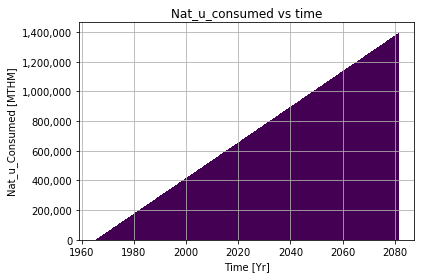

In [14]:
def nat_u_timeseries(cur):
    """ Finds natural uranium supply from source
        Since currently the source supplies all its capacity,
        the timeseriesenrichmentfeed is used.

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    -------
    get_timeseries: function
        calls a function that returns timeseries list of natural U
        demand from enrichment [MTHM]
    """
    init_year, init_month, duration, timestep = get_timesteps(cur)
    # Get Nat U feed to enrichment from timeseriesenrichmentfeed
    feed = cur.execute('SELECT time, sum(value) '
                       'FROM timeseriesenrichmentfeed '
                       'GROUP BY time').fetchall()

    return get_timeseries_cum(feed, duration, True)


def get_timeseries_cum(in_list, duration, kg_to_tons):
    """ returns a timeseries list from in_list data.

    Parameters
    ----------
    in_list: list
        list of data to be created into timeseries
        list[0] = time
        list[1] = value, quantity
    multiplyby: int
        integer to multiply the value in the list by for
        unit conversion from kilograms
    kg_to_tons: bool
        if True, list returned has units of tons
        if False, list returned as units of kilograms

    Returns
    -------
    timeseries of commodities in kg or tons
    """
    value = 0
    value_timeseries = []
    array = np.array(in_list)
    if len(in_list) > 0:
        for i in range(0, duration):
            value += sum(array[array[:, 0] == i][:, 1])
            if kg_to_tons:
                value_timeseries.append(value * 0.001)
            else:
                value_timeseries.append(value)
    return value_timeseries


img_out = 'analysis/results/' + region + '/'
name = 'Nat_u_consumed vs time'
consumption = {'Nat_u_consumption': nat_u_timeseries(cursor)}
an.stacked_bar_chart(consumption, timestep,
                     'Time [Yr]', 'Nat_u_Consumed [MTHM]',
                     name, img_out + name, ini_yr)

Image(filename=img_out + name + '.png')

As shown in the figure above, natural uranium consumed over the period of the simulation linearly increases. This demonstrates the constant rate of fuel processing performed by the enrichment facility regardless of the demand for fresh fuel. This will hopefully be improved in the future so that the enrichment facilities take the demand for fresh fuel into account.

__Amount of fuel into reactors vs. time__

A more accurate analysis for fuel consumption is the amount of fuel sent to reactors over time. While the enrichment facility constantly produces fresh fuel, the total amount of fuel sent to reactors changes based on the number and size of the reactors in operation at each timestep. This analysis is performed with `fuel_into_reactors` function. The function makes an sqlite query to the `resources`, `transactions`, and `agententry` table to obtain the amount of fuel sent to reactors throughout the simulation. The resulting data was sent to `get_timeseries_cum` function to obtain a timeseries list of different types of fuel sent to reactors throughout the simulation.

/home/gyutae/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1717: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


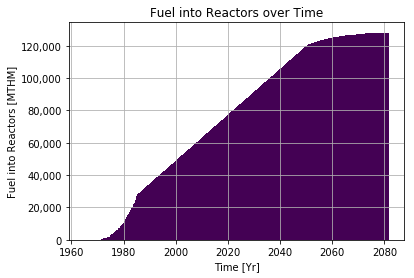

In [15]:
def fuel_into_reactors(cur):
    """ Finds timeseries of mass of fuel received by reactors

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    -------
    timeseries list of fuel into reactors [tons]
    """
    init_year, init_month, duration, timestep = get_timesteps(cur)
    fuel = cur.execute('SELECT time, sum(quantity) FROM transactions '
                       'INNER JOIN resources ON '
                       'resources.resourceid = transactions.resourceid '
                       'INNER JOIN agententry ON '
                       'transactions.receiverid = agententry.agentid '
                       'WHERE spec LIKE "%Reactor%" '
                       'GROUP BY time').fetchall()

    return get_timeseries_cum(fuel, duration, True)


name = 'Fuel into Reactors over Time'
to_reactor = {'Fuel_to_reactor': fuel_into_reactors(cursor)}
an.stacked_bar_chart(to_reactor, timestep,
                     'Time [Yr]', 'Fuel into Reactors [MTHM]',
                     name, img_out + name, ini_yr)

Image(filename=img_out + name + '.png')

As shown in the figure above, the fuel into reactors over time is not linear and changes with fuel demand of the reactors. This figure reflectes the state of the reactors (whether they were operating or refueling), and the number of reactors operating within the simulation. From the plot, the number of reactors greatly increased around 1980s.

__Fuel utilization vs. time__

Fuel utilization factor is the ratio of fuel spent to the amount of natural uranium consumed. While, fuel utilization factor is a value of interest, it is inaccurate at the moment of this investigation because the enrichment facilities in _CYCLUS_ does not perform a demand-driven fuel enrichment. Since the amount of natural uranium consumed is not accurate, fuel utilization factor, a derived variable, is also inaccurate. However, the functions used to calculate the fuel utilization factor over time is displayed for future usage. This is performed with `u_util_calc` function, which runs `nat_u_timeseries` function and `fuel_into_reactors` function to obtain the timeseries lists of natural uranium consumed and the amount of fuel consumed. Then, and element-wise division of the two lists were performed to obtain the fuel utilization factor.

/home/gyutae/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/gyutae/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1717: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


The Average Fuel Utilization Factor is: 
0.10001571039050017


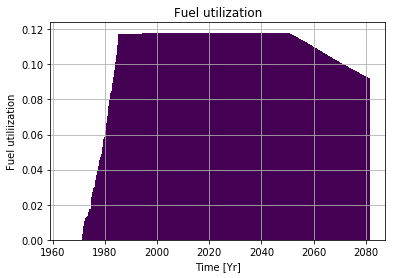

In [16]:
def u_util_calc(cur):
    """ Returns fuel utilization factor of fuel cycle

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    -------
    u_util_timeseries: numpy array
        Timeseries of Uranium utilization factor
    Prints simulation average Uranium Utilization
    """
    # timeseries of natural uranium
    u_supply_timeseries = np.array(nat_u_timeseries(cur))

    # timeseries of fuel into reactors
    fuel_timeseries = np.array(fuel_into_reactors(cur))

    # timeseries of Uranium utilization
    u_util_timeseries = np.nan_to_num(fuel_timeseries / u_supply_timeseries)
    print('The Average Fuel Utilization Factor is: ')
    print(sum(u_util_timeseries) / len(u_util_timeseries))

    return u_util_timeseries


name = 'Fuel utilization'
fuel_util = {'Fuel Utilization Factor': u_util_calc(cursor)}
an.stacked_bar_chart(fuel_util, timestep,
                     'Time [Yr]', 'Fuel utiliization',
                     name, img_out + name, ini_yr)

Image(filename=img_out + name + '.png')

__Capacity vs. time__

Total capacity over time is obtained using `get_power_dict` function and `capacity_calc` function. The `get_power_dict` function performs four sqlite queries to obtain the following: simulation start date, timesteps, institutions declared in _CYCLUS_, and reactors entry and exit timesteps. The results are sent to `capacity_calc` function, which calculates the timeseries value of the total capacity of the reactors in each institution.

FuelCycle has no values


/home/gyutae/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1717: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


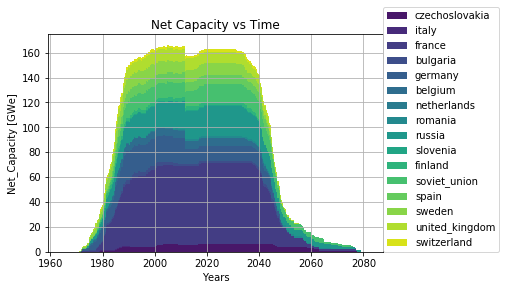

In [17]:
def get_power_dict(cur):
    """ Gets dictionary of power capacity by calling capacity_calc

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    ------
    power_dict: dictionary
        "dictionary with key=government, and
        value=timeseries list of installed capacity"
    """
    init_year, init_month, duration, timestep = get_timesteps(cur)
    governments = get_inst(cur)

    # get power cap values
    entry = cur.execute('SELECT max(value), timeseriespower.agentid, '
                        'parentid, entertime FROM agententry '
                        'INNER JOIN timeseriespower '
                        'ON agententry.agentid = timeseriespower.agentid '
                        'GROUP BY timeseriespower.agentid').fetchall()

    exit_step = cur.execute('SELECT max(value), timeseriespower.agentid, '
                            'parentid, exittime FROM agentexit '
                            'INNER JOIN timeseriespower '
                            'ON agentexit.agentid = timeseriespower.agentid'
                            ' INNER JOIN agententry '
                            'ON agentexit.agentid = agententry.agentid '
                            'GROUP BY timeseriespower.agentid').fetchall()

    return capacity_calc(governments, timestep, entry, exit_step)


def get_inst(cur):
    """ Returns prototype and agentids of institutions

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    -------
    sqlite query result (list of tuples)
    """
    return cur.execute('SELECT prototype, agentid FROM agententry '
                       'WHERE kind = "Inst"').fetchall()


def capacity_calc(governments, timestep, entry, exit_step):
    """Adds and subtracts capacity over time for plotting

    Parameters
    ----------
    governments: list
        list of governments (countries)
    timestep: np.linspace
        list of timestep from 0 to simulation time
    entry: list
        power_cap, agentid, parentid, entertime
        of all entered reactors
    exit_step: list
        power_cap, agentid, parenitd, exittime
        of all decommissioned reactors

    Returns
    -------
    power_dict: dictionary
        "dictionary with key=government, and
        value=timeseries list capacity"
    """
    power_dict = collections.OrderedDict()
    for gov in governments:
        capacity = []
        cap = 0
        for t in timestep:
            for enter in entry:
                if (enter['entertime'] == t and
                        enter['parentid'] == gov['agentid']):
                    cap += enter['max(value)'] * 0.001
            for dec in exit_step:
                if (dec['exittime'] == t and
                        dec['parentid'] == gov['agentid']):
                    cap -= dec['max(value)'] * 0.001
            capacity.append(cap)
        power_dict[gov['prototype']] = np.asarray(capacity)

    return power_dict


name = 'Net Capacity vs Time'
capacity_dict = get_power_dict(cursor)
an.stacked_bar_chart(capacity_dict, timestep,
                     'Years', 'Net_Capacity [GWe]',
                     name, img_out + name, ini_yr)

Image(filename=img_out + name + '.png')

As shown in the figure above, the net capacity greatly increases between 1970 and 1990. The increase in capacity reflects the increase in the number of reactors in operation. Then, the capacity decreases suddenly around 2010. This reflects the Fukushima Daiichi nuclear incident and Germany's subsequent decision to move away from nuclear energy. As shown in the figure above, the net capacity decreases by approximately 10 GWe.

__Number of reactors vs time__

A very similar procedure is used to obtain the number of reactors over time. The same four queries made to calculate capacity over time are made to get the number of reactors over time. Then, the result of the queries is passed to `reactor_deployments` function, which calculates the number of reactors operating over time.  

FuelCycle has no values


/home/gyutae/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1717: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


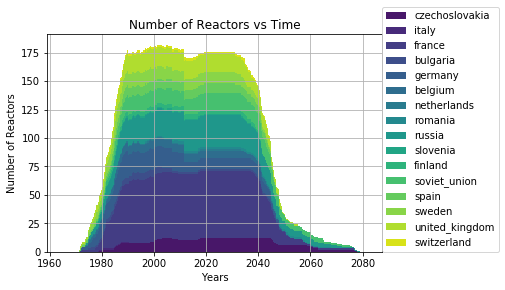

In [18]:
def get_deployment_dict(cur):
    """ Gets dictionary of reactors deployed over time
    by calling reactor_deployments

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    ------
    num_dict: dictionary
        "dictionary with key=government, and
        value=timeseries list of number of reactors"
    """
    init_year, init_month, duration, timestep = get_timesteps(cur)
    governments = get_inst(cur)

    # get power cap values
    entry = cur.execute('SELECT max(value), timeseriespower.agentid, '
                        'parentid, entertime FROM agententry '
                        'INNER JOIN timeseriespower '
                        'ON agententry.agentid = timeseriespower.agentid '
                        'GROUP BY timeseriespower.agentid').fetchall()

    exit_step = cur.execute('SELECT max(value), timeseriespower.agentid, '
                            'parentid, exittime FROM agentexit '
                            'INNER JOIN timeseriespower '
                            'ON agentexit.agentid = timeseriespower.agentid'
                            ' INNER JOIN agententry '
                            'ON agentexit.agentid = agententry.agentid '
                            'GROUP BY timeseriespower.agentid').fetchall()

    return reactor_deployments(governments, timestep, entry, exit_step)


def reactor_deployments(governments, timestep, entry, exit_step):
    """Adds and subtracts number of reactors deployed over time
    for plotting

    Parameters
    ----------
    governments: list
        list of governments (countries)
    timestep: np.linspace
        list of timestep from 0 to simulation time
    entry: list
        power_cap, agentid, parentid, entertime
        of all entered reactors

    exit_step: list
        power_cap, agentid, parenitd, exittime
        of all decommissioned reactors

    Returns
    -------
    deployment: dictionary
        "dictionary with key=government, and
        value=timeseries number of reactors"
    """
    deployment = collections.OrderedDict()
    for gov in governments:
        num_reactors = []
        count = 0
        for t in timestep:
            for enter in entry:
                if (enter['entertime'] == t and
                        enter['parentid'] == gov['agentid']):
                    count += 1
            for dec in exit_step:
                if (dec['exittime'] == t and
                        dec['parentid'] == gov['agentid']):
                    count -= 1
            num_reactors.append(count)
        deployment[gov['prototype']] = np.asarray(num_reactors)

    return deployment


name = 'Number of Reactors vs Time'
an.stacked_bar_chart(get_deployment_dict(cursor),
                     timestep, 'Years', 'Number of Reactors',
                     name, img_out + name, ini_yr)

Image(filename=img_out + name + '.png')

## Conclusion

To conclude, _CYCLUS_ performs simulations at a fairly accurate level as shown in the comparison of the power generation plots. However, some improvements in _CYCLUS_ are benefitial in producing a more accurate simulation: the implementation of an enrichment facility that processes fuel on a need basis. There were other improvements that can be potentially made for this simulation to improve its accuracy.

+  Specify actual burnup for reactors
    + Currently, the reactors deployed in Cyclus are all deployed with a burnup of 51 GWd/MTHM. 
    
    
+  Specify reactor n_assembly_core and batch
    + Reactors were deployed in cyclus without the actual number of assemblies per core and batch. The typical values were used for each reactor type (Source needs to be added for the typical values). While the effects of changing these values may not be significant in the outcome of the simulation, specifying such information may benefit the accuracy of the simulation results.
    
### References

[1] N. Todreas and M. Kazimi, Nuclear systems. Boca Raton, FL: CRC Press, 2012.


[2] D. Cacuci, Handbook of nuclear engineering. New York: Springer, 2010.